# Preliminary

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
import sys

import numpy as np
import pickle, random, string
import matplotlib.pyplot as plt
%matplotlib inline

# Visualization
from IPython.display import display

from pathlib import Path

In [2]:
# Ugly patch becasue idk how to make this propperly work
#sys.path[0] += '/Codebase'
sys.path

['/home/jovyan/Extrapolation-Exploration/Codebase',
 '/opt/conda/lib/python39.zip',
 '/opt/conda/lib/python3.9',
 '/opt/conda/lib/python3.9/lib-dynload',
 '',
 '/opt/conda/lib/python3.9/site-packages']

In [3]:
#my classes
#from testClass import *
from transformerClasses import *
from embeddingClasses import *
from lstmClasses import *
from resourceFunctions import *

2022-07-31 07:41:29.789646: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-31 07:41:29.789685: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-31 07:41:29.789717: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-lak3r): /proc/driver/nvidia/version does not exist
2022-07-31 07:41:29.790082: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
strategy = tf.distribute.OneDeviceStrategy('gpu:1')

# Loading Outer Model???

In [5]:
# setting up the pathlib stuff 
path = Path('..')
print([x for x in path.iterdir() if x.is_dir()])

path = path / 'saved-models'
outPath = path / 'outer_encdec_intembed'

encPathJson = outPath / 'encoder_len5_J_10000_intembed.json'
decPathJson = outPath / 'decoder_len5_J_10000_intembed.json'
encPathH5 = outPath / 'encoder_len5_J_10000_intembed.h5'
decPathH5 = outPath / 'decoder_len5_J_10000_intembed.h5'

[PosixPath('../.ipynb_checkpoints'), PosixPath('../saved-models'), PosixPath('../Qualifying-Exam-Writings'), PosixPath('../Codebase'), PosixPath('../data'), PosixPath('../.git')]


In [6]:
with encPathJson.open() as encoder_file, decPathJson.open() as decoder_file:
    encoder_json = encoder_file.read()
    decoder_json = decoder_file.read()
outer_encoder = keras.models.model_from_json(encoder_json)
outer_decoder = keras.models.model_from_json(decoder_json)
outer_encoder.load_weights(encPathH5)
outer_decoder.load_weights(decPathH5)

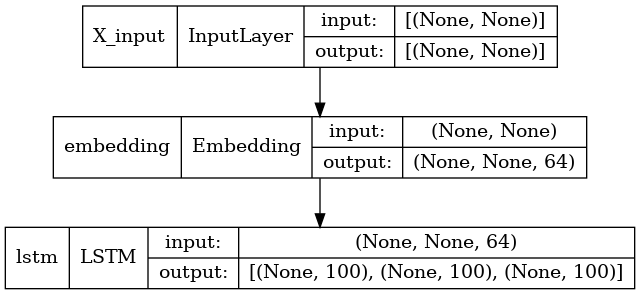

In [17]:
keras.utils.plot_model(outer_encoder, show_shapes=True)

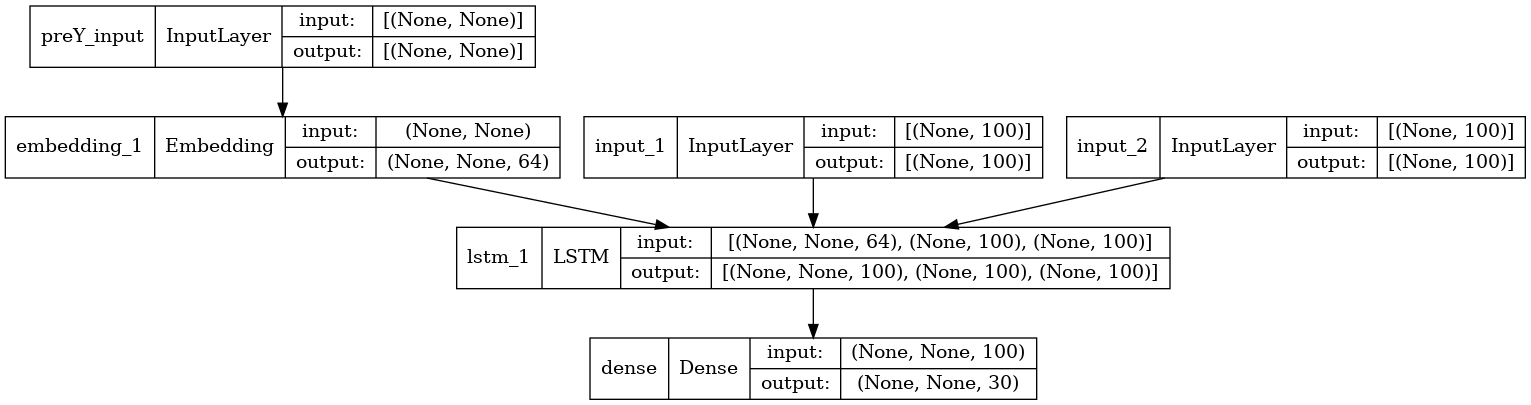

In [18]:
keras.utils.plot_model(outer_decoder, show_shapes=True)

# Load Input Data ???

In [7]:
# corpus = np.loadtxt(sys.argv[1], dtype=object) #open('../thesis-master/data/len5_10000-train.txt')#
# trainingSet = np.loadtxt(sys.argv[2], dtype=object) #open('../thesis-master/data/SG-10-train.txt')
# testingSet  = np.loadtxt(sys.argv[3], dtype=object)#open('../thesis-master/data/SG-10-test.txt')

In [8]:
corpus = open('../data/len5_10000-train.txt')#corpus = np.loadtxt(sys.argv[1], dtype=object)
corpus = np.loadtxt(corpus, dtype=object)

trainingSet = open('../data/SG-10-train.txt')
testingSet  = open('../data/SG-10-test.txt')

trainingSet = np.loadtxt(trainingSet, dtype=str)
testingSet  = np.loadtxt(testingSet, dtype=str)

#Do note that I'm not confident in this

In [9]:
# --- Create a dictionary for all the letters & start/stops ---
alphabet = np.array([i for i in range(1, 31)]) # All letters plus STARTSENTENCE, STOPSENTENCE, start, stop
mapping = dict()
for i in range(len(alphabet) - 4):
    mapping[chr(ord('a') + i)] = alphabet[i]

mapping['start'] = alphabet[26]
mapping['stop']  = alphabet[27]
mapping['STARTSETNENCE'] = alphabet[28]
mapping['STOPSENTENCE']  = alphabet[29]

In [10]:
# --- Map words from corpus to words to roles ---
encoded_mapping = {}
selected_words = {}
for letter in string.ascii_lowercase[:10]:
    # Store the letter with the word for use in testing
    rand_corpus_word = random.choice(corpus)

    word, Y, preY, postY = word_to_int(rand_corpus_word, mapping)
    
    selected_words[letter] = postY
    
    encoded_mapping[letter] = outer_encoder.predict(np.array([word]))

In [11]:
#--- Pre input to make encodings at the sentence level --- 
roles   = trainingSet #argv[2]    
x_train = []
for sentence in roles:
    x_train.append([encoded_mapping[letter] for letter in sentence])
x_train = np.array(x_train) # shape (n, 3, 2, 1, 50)

LENGTH_IDK  = x_train.shape[-1] # Replacing '50' in the code

t1 = x_train[:,:,0,0,:] # new shape (n,3,50)
t2 = x_train[:,:,1,0,:] # " '' "
# 4 time steps. pre
pre_t1 = np.concatenate((np.zeros((x_train.shape[0],1,LENGTH_IDK)), t1), axis = 1) # Orig. (x_train.shape[0], 1, 50)
pre_t2 = np.concatenate((np.zeros((x_train.shape[0],1,LENGTH_IDK)), t2), axis = 1)
post_t1 = np.concatenate((t1, np.zeros((x_train.shape[0],1,LENGTH_IDK))), axis = 1)
post_t2 = np.concatenate((t2, np.zeros((x_train.shape[0],1,LENGTH_IDK))), axis = 1)

In [12]:
# Start or stop tokens
s_s = {"start": [0,1], "stop": [1,0], "none": [0,0]}
pre_t3 = np.zeros((x_train.shape[0], 4, 2))
post_t3 = np.copy(pre_t3)
pre_t3[:,0,:] = s_s["start"]
post_t3[:,3,:] = s_s["stop"]

# Inner LSTM ???

In [ ]:
# --- Set hyperparameters ---
HIDDEN_SIZE = 300
BATCH_SIZE  = 100
EPOCHS      = 1600

with strategy.scope():
    # --- Construct inner encoder/decoder ---
    encoder_input_t1 = keras.layers.Input(shape=(None, t1.shape[2]), name="enc_token_1")
    encoder_input_t2 = keras.layers.Input(shape=(None, t1.shape[2]), name="enc_token_2")
    encoder_input = keras.layers.Concatenate()([encoder_input_t1, encoder_input_t2])

    encoder_hidden = keras.layers.LSTM(HIDDEN_SIZE, return_state=True, name="FUTURE_TRANSFORMER")
    # Tie them together
    encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
    # Don't need the encoder outputs, just need the states.
    encoder_states = [enc_state_h, enc_state_c]

    decoder_input_t1 = keras.layers.Input(shape=(None, t1.shape[2]), name="dec_token_1")
    decoder_input_t2 = keras.layers.Input(shape=(None, t1.shape[2]), name="dec_token_2")
    decoder_input_t3 = keras.layers.Input(shape=(None, 2), name="dec_start/stop")
    decoder_input = keras.layers.Concatenate()([decoder_input_t1, decoder_input_t2, decoder_input_t3])

    decoder_hidden = keras.layers.LSTM(HIDDEN_SIZE, return_sequences=True, return_state=True, name="FUTURE_MASKED_TRANSFORMER")
    # Tie it together
    decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                             initial_state=encoder_states)
    decoder_dense_t1 = keras.layers.Dense(t1.shape[2], activation='linear', name="token_1")
    decoder_dense_t2 = keras.layers.Dense(t1.shape[2], activation='linear', name="token_2")
    decoder_dense_t3 = keras.layers.Dense(2, activation='sigmoid', name="start/stop")
    # Connect output to hidden
    decoder_output = [decoder_dense_t1(decoder_hidden_output), decoder_dense_t2(decoder_hidden_output), decoder_dense_t3(decoder_hidden_output)]

    model = keras.Model([encoder_input_t1, encoder_input_t2, decoder_input_t1, decoder_input_t2, decoder_input_t3], decoder_output)

    model.compile(loss = [keras.losses.MSE, keras.losses.MSE, keras.losses.binary_crossentropy],
                   optimizer=keras.optimizers.Adam(),
                   metrics=['accuracy'])

    model_input = {"enc_token_1": t1, "enc_token_2": t2, "dec_token_1": pre_t1, "dec_token_2": pre_t2, "dec_start/stop": pre_t3}
    model_target = {"token_1": post_t1, "token_2": post_t2, "start/stop": post_t3}

    # --- Train model ---
    history = model.fit(model_input, model_target,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=0)
    #accuracy = model.evaluate(model_input, model_target) # use `model.metrics_names` to get indices for accuracy:

    # --- Restructure the model without teacher forcing ---
    encoder_model = keras.Model([encoder_input_t1, encoder_input_t2], encoder_states)

    # Decoder
    decoder_state_input_h = keras.layers.Input(shape=(HIDDEN_SIZE,), name="states_input_h")
    decoder_state_input_c = keras.layers.Input(shape=(HIDDEN_SIZE,), name="states_input_c")
    # inputs to hidden
    decoder_states_input = [decoder_state_input_h, decoder_state_input_c]
    decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                             initial_state=decoder_states_input)
    decoder_states = [decoder_state_h, decoder_state_c]
    # hidden to outputs

    decoder_output = [decoder_dense_t1(decoder_hidden_output), decoder_dense_t2(decoder_hidden_output), decoder_dense_t3(decoder_hidden_output)]
    decoder_model = keras.Model(
        [decoder_input_t1, decoder_input_t2, decoder_input_t3] + decoder_states_input,
        decoder_output + decoder_states)

    # --- Extract the model's output from inner then outer decoder ---
    x_test = []
    correct_result = [] # used to get accuracy at end
    roles = testingSet #argv[3]
    for sentence in roles:
        x_test.append([encoded_mapping[letter] for letter in sentence])
        correct_result.append([selected_words[letter] for letter in sentence])

    x_test = np.array(x_test) # shape (n, 3, 2, 1, 50)
    correct_result = np.array(correct_result)

    t1 = x_test[:,:,0,0,:] # new shape (n,3,50)
    t2 = x_test[:,:,1,0,:] # " '' "
    # 4 time steps. pre
    pre_t1 = np.concatenate((np.zeros((x_test.shape[0],1,LENGTH_IDK)), t1), axis = 1)
    pre_t2 = np.concatenate((np.zeros((x_test.shape[0],1,LENGTH_IDK)), t2), axis = 1)

    # Start tokens
    pre_t3 = np.zeros((x_test.shape[0], 4, 2))
    pre_t3[:,0,:] = s_s["start"]

    outer_result = np.empty((len(x_test),3,6))

    for i, sentence in enumerate(x_test):
        context = encoder_model.predict({"enc_token_1": t1[i:i+1], "enc_token_2": t2[i:i+1]})
        dec_t1 = np.zeros((1,1,LENGTH_IDK))
        dec_t2 = np.zeros((1,1,LENGTH_IDK))
        dec_s_s = pre_t3[0:1,0:1,:]
        inner_result = np.zeros([4,2,LENGTH_IDK])
        output_length = 3

        # obtain the result from the inner decoder
        for x in range(output_length+1):
            out1, out2, out3, h, c = decoder_model.predict({"states_input_h": context[0], 
                                             "states_input_c": context[1],
                                             "dec_token_1": dec_t1,
                                             "dec_token_2": dec_t2,
                                             "dec_start/stop": dec_s_s})
            context = [h,c]
            dec_t1 = out1
            dec_t2 = out2
            dec_s_s = out3
            inner_result[x,0,:] = out1
            inner_result[x,1,:] = out2

        # obtain the result from the outer decoder
        output_length = 5
        for word in range(3):
            context = []
            context.append(inner_result[word,0:1,:])
            context.append(inner_result[word,1:2,:])
            token = np.array(mapping["start"])
            token = token.reshape([1, 1, 1])
            for letter in range(output_length + 1):
                out, h, c = outer_decoder.predict([token] + context)
                token = Out_to_int(out)
                context = [h,c]
                outer_result[i, word, letter] = token

2022-07-31 07:43:15.692247: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_4372"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:134"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 100
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. Y

2022-07-31 07:44:46.408270: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_63370"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:1883"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. 

In [ ]:
# --- Get letter and word level accuracy ---
word_accuracy = 0
letter_accuracy = 0
for answer, response in zip(correct_result, outer_result):
    # check each word
    for word in range(3):
        if np.array_equal(answer[word,:], response[word,:]):
            word_accuracy += 1
            letter_accuracy += 6
        #check each letter
        else:
            for letter in range(6):
                if np.array_equal(answer[word,letter], response[word,letter]):
                    letter_accuracy += 1
                    
word_accuracy /= float(correct_result.shape[0] * 3)
letter_accuracy /= float(correct_result.shape[0] * 3 * 6)

In [ ]:
print('-----------------------------')
print('''   Generalization Accuracy
-----------------------------
word_accuracy: %f
letter_accuracy: %f
'''%((word_accuracy*100), (letter_accuracy*100)))

# --- Write results to file ---
my_file = str(sys.argv[2][0:2]) + "_output.txt"

file_object = open(my_file, 'a')
# Append 'hello' at the end of file
file_object.write("word_accuracy: " + str(word_accuracy*100) + '\n')

file_object.write("letter_accuracy: " + str(letter_accuracy*100) + '\n')
# Close the file
file_object.close()